# Is it a hot dog, or not (dog)?

This is an attempt at classifying a set of images as either hot dogs or not hot
dogs. I'll be using tensorflow, and a hotdog image set with training data found online.

In [209]:
import sys

In [210]:
!{sys.executable} -m pip install tensorflow

In [211]:
import os
from os.path import join
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [212]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


In [213]:
image_size = 224

## imports images and outputs an array
def prep_images(img_paths, img_height=image_size, img_width=image_size):
    ## loading images in the image paths
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]


    ## converting images to arrays and returning
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    print(np.shape(imgs[0]))
    print(np.shape(img_array[0]))
    return (output)

We can now get the training data, they will be in categories either "hot dog" or
"not hot dog"

In [214]:
train_hotdog_dir    = 'C:\\Users\\nburw\\OneDrive\\Desktop\\train\\hot_dog'
train_nothotdog_dir = 'C:\\Users\\nburw\\OneDrive\\Desktop\\train\\not_hot_dog'

Quick test to make sure directories are okay

In [215]:
print(train_hotdog_dir)
print(train_nothotdog_dir)

C:\Users\nburw\OneDrive\Desktop\train\hot_dog
C:\Users\nburw\OneDrive\Desktop\train\not_hot_dog


In [216]:
train_hotdog_filenames      = os.listdir(train_hotdog_dir)
train_nothotdog_filenames   = os.listdir(train_nothotdog_dir)

#print(train_hotdog_filenames)

In [217]:

hotdog_paths       = [(train_hotdog_dir    + '\\' + train_hotdog_filenames[i])    for i in range(len(train_hotdog_filenames))]
nothotdog_paths    = [(train_nothotdog_dir + '\\' + train_nothotdog_filenames[i]) for i in range(len(train_nothotdog_filenames))]

#print(hotdog_paths[0])
#print(nothotdog_paths[0])

Cool, so now we have a way to get paths for individual images, so we can start
getting tensorflow out now. That was a bit of a lie, but first we need to get
the training set setup. Training sets are gonna be an array of x,y pairs where x
is an image (as an array) and y is a value from 0 to 1 where 1 means it's a hot
dog, and 0 means it's not a hot dog.

In [223]:
prepped_hotdogs     = prep_images(hotdog_paths)
prepped_nothotdogs  = prep_images(nothotdog_paths)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


Now we convert into the xy pair

In [241]:
x_train = np.concatenate((prepped_hotdogs, prepped_nothotdogs))
y_train = np.array([(1 if n <= 249 else 0) for n in range(len(x_train))])

print(np.shape(x_train), np.shape(y_train))


(498, 224, 224, 3) (498,)


In [255]:
## now we shuffle them in unison
assert len(x_train) == len(y_train)

##    Example    ##
a = np.array([1, 2, 3, 4, 5])
b = np.array([-1, -2, -3, -4, -5])

p = np.random.permutation(len(a))
print(a[p])
print(b[p])
## Example (end) ##

## actual unison shuffle of data
shuffler = np.random.permutation(len(x_train))
y_train = y_train[shuffler]
x_train = x_train[shuffler]

[4 1 5 2 3]
[-4 -1 -5 -2 -3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


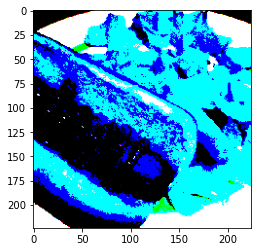

In [263]:
import matplotlib.pyplot as plt
plt.imshow(prepped_hotdogs[1])
print(np.shape(prepped_hotdogs[0]))

Okay so now we have our training data setup. We are going to setup our model
using tf.keras now.

# Developing Models

For our first attempt, we will be using a convolutional network

In [257]:
## Our first attempt will be a generic sequential model with 4 layers
model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
    ])

Here we define a loss function

In [258]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Frankly, I don't understand this part, or what the output means

In [259]:
predictions = model_v1(x_train[:1]).numpy()
print(predictions)

[[-12.270783   -7.8165493]]


In [262]:
tf.nn.softmax(predictions).numpy()

array([[0.01149554, 0.98850447]], dtype=float32)

Does this mean the model is predicting that this image is a hotdog? I don't
completely understand...

Compile the model

In [260]:
model_v1.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Time to train

In [261]:
model_v1.fit(x_train, y_train, epochs=5)

Epoch 1/5
16/16 [==============================] - 23s 1s/step - loss: 854.3769 - accuracy: 0.4880
Epoch 2/5
16/16 [==============================] - 20s 1s/step - loss: 79.9865 - accuracy: 0.6667
Epoch 3/5
16/16 [==============================] - 21s 1s/step - loss: 5.3621 - accuracy: 0.8514
Epoch 4/5
16/16 [==============================] - 22s 1s/step - loss: 0.5619 - accuracy: 0.9639
Epoch 5/5
16/16 [==============================] - 26s 2s/step - loss: 0.0899 - accuracy: 0.9900


Okay, so now we want to test our data, so we need to create a testing set. After
that, we will evaluate our model, and play around with a few different model
setups to determine the impact on our accuracy.

# Developing Test Data

So now we need to go through and develop a test data set. What we are going to
do is grab images from our training data set which contains no shared images of
hotdogs, so the model can't just identify something it already was trained on.
We will quickly run through the same steps we did in the beginning.

In [264]:
test_hotdog_dir    = 'C:\\Users\\nburw\\OneDrive\\Desktop\\test\\hot_dog'
test_nothotdog_dir = 'C:\\Users\\nburw\\OneDrive\\Desktop\\test\\not_hot_dog'

test_hotdog_filenames      = os.listdir(test_hotdog_dir)
test_nothotdog_filenames   = os.listdir(test_nothotdog_dir)

hotdog_paths_test       = [(test_hotdog_dir    + '\\' + test_hotdog_filenames[i])    for i in range(len(test_hotdog_filenames))]
nothotdog_paths_test    = [(test_nothotdog_dir + '\\' + test_nothotdog_filenames[i]) for i in range(len(test_nothotdog_filenames))]

In [265]:
prepped_hotdogs_test     = prep_images(hotdog_paths_test)
prepped_nothotdogs_test  = prep_images(nothotdog_paths_test)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [266]:
x_test = np.concatenate((prepped_hotdogs_test, prepped_nothotdogs_test))
y_test = np.array([(1 if n <= 249 else 0) for n in range(len(x_test))])

print(np.shape(x_test), np.shape(y_test))

(500, 224, 224, 3) (500,)


In [267]:
## now we shuffle them in unison
assert len(x_test) == len(y_test)

## actual unison shuffle of data
shuffler = np.random.permutation(len(x_test))
y_test = y_test[shuffler]
x_test = x_test[shuffler]

In [269]:
model_v1.evaluate(x_test,  y_test, verbose=1)

16/16 [==============================] - 4s 219ms/step - loss: 9.3722 - accuracy: 0.4900


[9.37216854095459, 0.49000000953674316]

OK so now that we have a model, and we've tested it (and it frankly worked out
quite poorly) we are gonna start playing around with different models.

# Playing with Different Models

First and foremost, I'm going to print out the model_v1 summary so we know what
layers we had originally

In [271]:
model_v1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 flatten_5 (Flatten)         (None, 1548800)           0         
                                                                 
 dropout_5 (Dropout)         (None, 1548800)           0         
                                                                 
 dense_7 (Dense)             (None, 2)                 3097602   
                                                                 
Total params: 3,102,690
Trainable params: 3,102,690
Non-trainable params: 0
_________________________________________________________________


Immediately I'm curious about what happens if I don't use convolutions, and
instead use a much simpler model. I'll be using just a 4 layer sequential model
to see how it goes. My immediate prediction is that I will have a worse
accuracy, so let's see what happens.

## Model_v2

In [290]:
model_v2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2)
])

In [291]:
model_v2.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [292]:
model_v2.fit(x_train, y_train, epochs=6)

Epoch 1/6
14/16 [=========================>....] - ETA: 0s - loss: 3298.0042 - accuracy: 0.5112

Immediately we can tell this is going worse. I expected we'd need more epochs to
get to a similar level of accuracty for the training data, and I was right. I
don'tknow if adding more is useful becuase it seems to platue

In [278]:
model_v2.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 1s 41ms/step - loss: 1670.8032 - accuracy: 0.4780


[1670.80322265625, 0.4779999852180481]

Surprisingly close to the original convolutional model... Let's try another
convolutional mode, but which has more dense layers. I'm going to include a
dense layer before the first conv layer to see if that helps at all.

## Model_v3

In [286]:
## Our first attempt will be a generic sequential model with 4 layers
model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
    ])

In [287]:
model_v3.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [288]:
model_v3.fit(x_train, y_train, epochs=6)

Epoch 1/6
16/16 [==============================] - 108s 6s/step - loss: 368.6917 - accuracy: 0.5201
Epoch 2/6
16/16 [==============================] - 134s 8s/step - loss: 33.3654 - accuracy: 0.6225
Epoch 3/6
16/16 [==============================] - 119s 7s/step - loss: 3.8088 - accuracy: 0.8173
Epoch 4/6
16/16 [==============================] - 125s 8s/step - loss: 0.5800 - accuracy: 0.9378
Epoch 5/6
16/16 [==============================] - 124s 8s/step - loss: 0.1246 - accuracy: 0.9900
Epoch 6/6
16/16 [==============================] - 121s 8s/step - loss: 0.0804 - accuracy: 0.9819


In [289]:
model_v3.evaluate(x_test, y_test, verbose=1)

16/16 [==============================] - 17s 996ms/step - loss: 8.9771 - accuracy: 0.4580


[8.977143287658691, 0.4580000042915344]

Okay so clearly that was a bad idea! The model performed worse than any of the
models thus far. It also took forever, and I'm wondering if I should have
flattened after my first dense layer and then after the second convolutional
layer. In either case, I'm going to try something else out.